In [9]:
import pickle as pkl
import pandas as pd
import matplotlib.pyplot as plt
import networkx as nx
import numpy as np

with open('training_data.pkl', 'rb') as file:
    train_graphs = pkl.load(file)
# with open('test_data.pkl', 'rb') as file:
    # test_graphs = pkl.load(file)
with open('training_labels.pkl', 'rb') as file:
    train_labels = pkl.load(file)

# define your learning algorithm here
# for instance, define an object called ``classifier''  
# classifier.train(train_labels,train_graphs)


# predict on the test data
# for instance, test_preds = classifier.predict(test_graphs)

# Yte = {'Prediction' : test_preds}
# dataframe = pd.DataFrame(Yte)
# dataframe.index += 1
# dataframe.to_csv('test_pred.csv',index_label='Id')

## Day 1

In [10]:
pd.unique(train_labels)
pd.value_counts(train_labels)

0    5445
1     555
dtype: int64

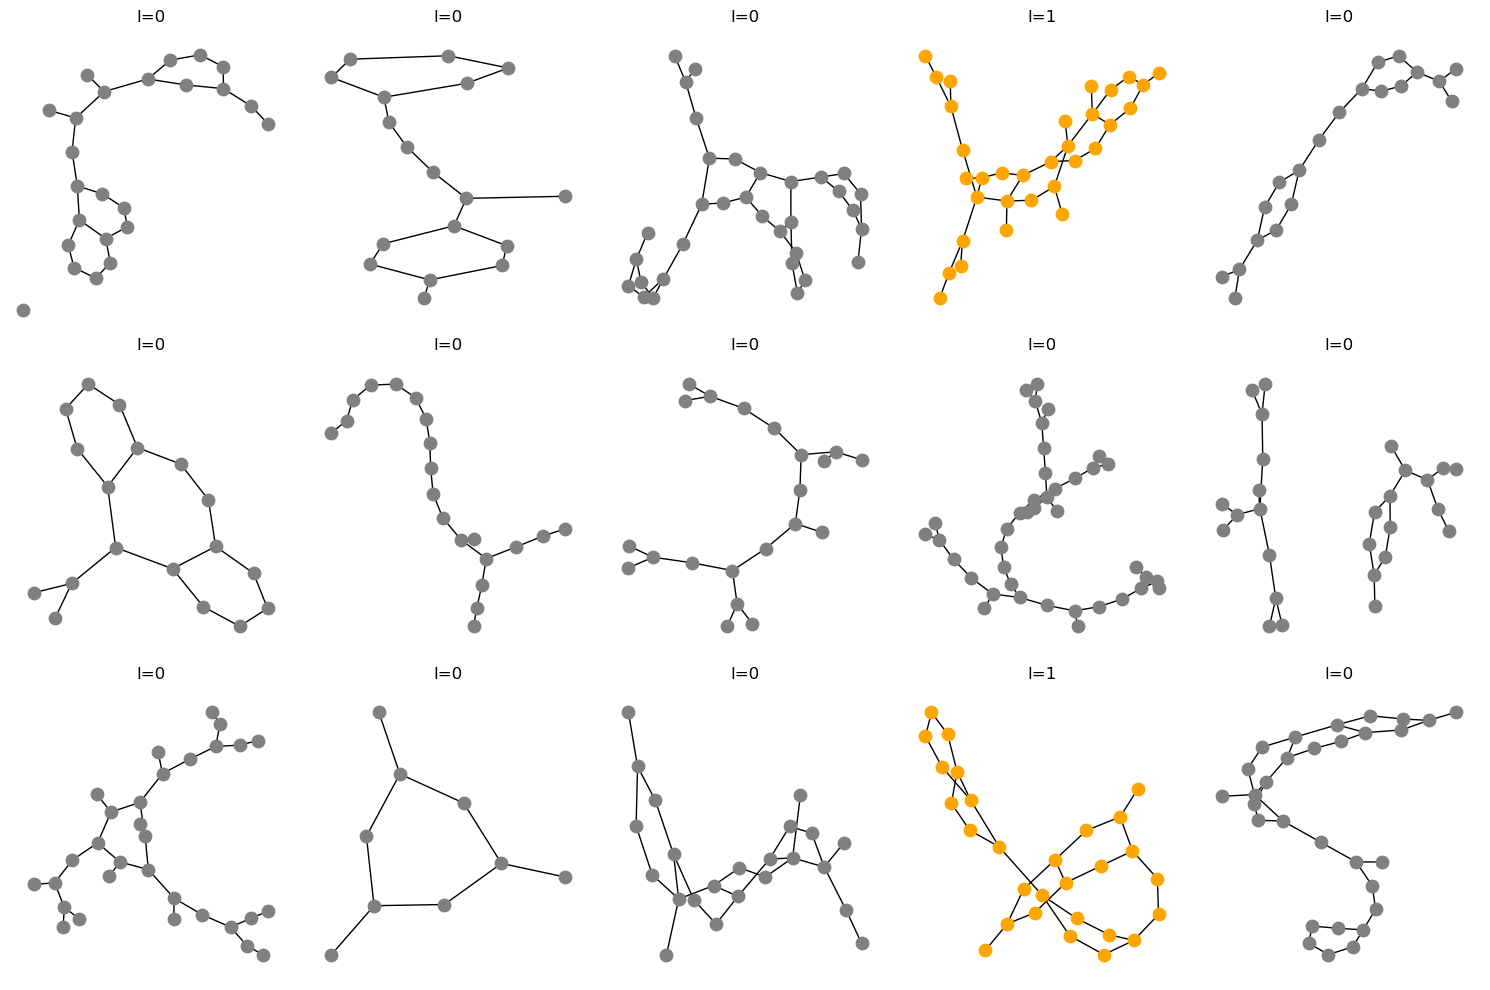

In [11]:
import matplotlib.pyplot as plt
import networkx as nx

plt.figure(figsize=(15,10), tight_layout=True)
i = 1
c = ['gray', 'orange']
for _ in range(3):
    for _ in range(5):
        plt.subplot(3,5,i)
        nx.draw(train_graphs[i], node_color= (c[0] if train_labels[i]==0 else c[1])  , node_size=80)
        plt.title(f'l={train_labels[i]}') #c = {len(sorted(nx.connected_components(train_graphs[i]), key=len, reverse=True))}, 
        i = i+1

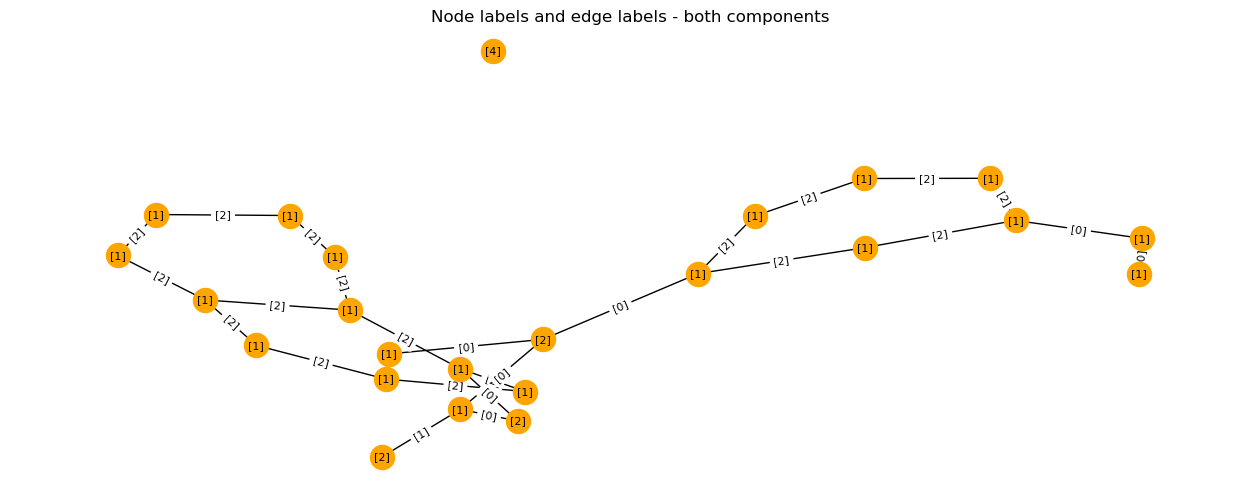

In [55]:
def plotGraph(G):
    plt.figure(figsize=(16,6))
    plt.title('Node labels and edge labels - both components')
    pos = nx.spring_layout(G, seed=2, k=0.3)
    nx.draw(G, pos, with_labels=False, node_color='orange')

    # nx.draw_networkx_edges(G, pos, edgelist=elist )
    edge_labels = nx.get_edge_attributes(G, "labels")
    node_labels = nx.get_node_attributes(G, "labels")
    nx.draw_networkx_edge_labels(G, pos, edge_labels, font_size=8)
    nx.draw_networkx_labels(G, pos, node_labels, font_size=8);

G = train_graphs[1]
plotGraph(G)

In [35]:
print(pd.value_counts([G.nodes[i]['labels'] for i in range(len(node_labels))]))
print(pd.value_counts([G.edges[i]['labels'] for i in G.edges]))


[1]    20
[2]     3
[4]     1
dtype: int64
[2]    17
[0]     7
[1]     1
dtype: int64


In [ ]:
G = G
nx.get_edge_attributes(G, 'labels')

In [ ]:
print('Nodes:\n', list(G.nodes))
print('Edges:\n', list(G.edges))
print('Neighbours:\n', list(G.adj[1]))  # or list(G.neighbors(1))
print('Degree:\n', G.degree[1])

In [ ]:
print(G.edges[0,1])
print((G.nodes[0]))
# print((G.nodes[0]['labels'])[0])

In [ ]:
print('Count number of connected components')
len(sorted(nx.connected_components(G), key=len, reverse=True))


In [ ]:
import scipy.sparse as ss
import numpy as np

print('Determine Laplacian')
#Find largest connected component 
G0 = G.subgraph(sorted(nx.connected_components(G), key=len, reverse=True)[0])
#Adjacency
A = nx.adjacency_matrix(G)  # ss.csr_matrix.toarray(nx.adjacency_matrix(G))
#Neighbours
D = np.array([len(list(G.neighbors(n))) for n in range(G.number_of_nodes())])
#Laplacian
L = np.diag(D) - A
Lstar = np.linalg.pinv(L)
# print(Lstar)

In [74]:
lengths = np.array([len(ADJ[i]) for i in range(len(ADJ))])
np.where(lengths==101)
G = train_graphs[np.where(lengths==101)[0][0]]
G = G.subgraph(sorted(nx.connected_components(G), key=len, reverse=True)[0])

# plotGraph(G)

node_labels = nx.get_node_attributes(G, "labels")
edge_labels = nx.get_edge_attributes(G, "labels")

n = pd.value_counts([G.nodes[i]['labels'] for i in range(len(node_labels))])

# print(pd.value_counts([G.nodes[i]['labels'] for i in range(len(node_labels))]))
# print(pd.value_counts([G.edges[i]['labels'] for i in G.edges]))


101

## Day 2

In [3]:
V = np.zeros(len(train_graphs))
E = np.zeros(len(train_graphs))
CC = np.zeros(len(train_graphs))
i = 0
for G in train_graphs:
    V[i] = len(list(G.nodes))
    E[i] = len(list(G.edges))
    CC[i] = len(sorted(nx.connected_components(G), key=len, reverse=True))
    i +=1

    stats = pd.DataFrame(np.vstack((V, E, CC)).T, columns=['V', 'E', 'CC'])
# stats.describe()

We have some graphs with no edges. Remove those

In [4]:
print(len(np.where(E==0)[0]))
train_graphs = np.delete(train_graphs, np.where(E==0)[0])
train_labels = np.delete(train_labels, np.where(E==0)[0])
print(f'removed {len(train_graphs)} data points')

7
removed 5993 data points


c:\Users\norti\anaconda3\lib\site-packages\numpy\lib\function_base.py:4454: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  arr = asarray(arr)


Generate spectral data

In [5]:
from tqdm import tqdm
import scipy.sparse as ss
ADJ = []
DEG = []
LAP = []
N = len(train_graphs)
for i in tqdm(range(N)):
    G = train_graphs[i]
    #Find largest connected component 
    G = G.subgraph(sorted(nx.connected_components(G), key=len, reverse=True)[0])    
    # Relabel to start from 0 so neigbours works
    G = nx.convert_node_labels_to_integers(G, first_label=0)
    #Adjacency
    A= ss.csr_matrix.toarray(nx.adjacency_matrix(G)) #nx.adjacency_matrix(G) # 
    #Neighbours
    D=np.array([len(list(G.neighbors(n))) for n in range(0, G.number_of_nodes())])        
    #Inverse squareroot
    D12 = np.diag(1/np.sqrt(D))
    #Identity
    I = np.eye(len(D12))
    #Generalised Laplacian
    LAP.append(I - D12.dot(A).dot(D12))
    ADJ.append(A)
    DEG.append(D)

print(len(LAP))

#mean of |V| = 16 so let's pick top 16 eigenvalues for each Laplacian
r = 16
spectral = np.zeros((len(LAP), r))
for i in range(len(LAP)):
    eigvals = np.linalg.eigvals(LAP[i])
    if len(eigvals)<r:
        spectral[i, 0:len(eigvals)] = eigvals
    else:
        spectral[i] = eigvals[0:r]

spectral.shape

  0%|          | 0/5993 [00:00<?, ?it/s]C:\Users\norti\AppData\Local\Temp\ipykernel_20544\1486064300.py:14: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  A= ss.csr_matrix.toarray(nx.adjacency_matrix(G)) #nx.adjacency_matrix(G) #
100%|██████████| 5993/5993 [00:03<00:00, 1605.82it/s]
C:\Users\norti\AppData\Local\Temp\ipykernel_20544\1486064300.py:36: ComplexWarning: Casting complex values to real discards the imaginary part
  spectral[i] = eigvals[0:r]
C:\Users\norti\AppData\Local\Temp\ipykernel_20544\1486064300.py:34: ComplexWarning: Casting complex values to real discards the imaginary part
  spectral[i, 0:len(eigvals)] = eigvals


5993


(5993, 16)

Let's rescale to $[-1,1]$

In [6]:
from scipy import optimize
import numpy as np
from sklearn.metrics.pairwise import euclidean_distances
class RBF:    
    def __init__(self, sigma=1.):
        self.sigma = sigma  ## the variance of the kernel
    def kernel(self,X,Y):
        # def evaluate(a,b):
        #     diff = a-b
        #     return np.exp( - np.dot(diff, diff) * len(a) / (2*self.sigma**2))
        # XX = np.apply_along_axis(lambda x1 : np.apply_along_axis(lambda x2:  evaluate(x1, x2), 1, Y), 1, X)    
        XX = np.exp(-euclidean_distances(X,Y, squared=True)/(2*self.sigma**2))
        return XX

class KernelSVC:
    
    def __init__(self, C, kernel, epsilon = 1e-3):
        self.type = 'non-linear'
        self.C = C                               
        self.kernel = kernel     
        self.alpha = None
        self.support = None
        self.epsilon = epsilon
        self.norm_f = None
       
    
    def fit(self, X, y):
       #### You might define here any variable needed for the rest of the code
        self.N = len(y)
        print('Start Kernel Calculation')
        K = self.kernel(X,X) 
        print('End Kernel Calculation')
        G = K * np.dot(y.reshape(-1, 1), y.reshape(1,-1))        
        

        # Lagrange dual loss
        def loss(alpha):
            return np.sum(alpha) - 0.5*alpha.dot(alpha.dot(G))

        # '''----------------partial derivative of the dual loss wrt alpha -----------------'''
        def grad_loss(alpha):
            return np.ones_like(alpha) - alpha.dot(G)
            

        # Constraints on alpha of the shape :
        # -  d - C*alpha  = 0
        # -  b - A*alpha >= 0
        A0 = -np.eye(self.N)
        b0 = np.zeros(self.N)
        bC = self.C * np.ones(self.N)
        AC = np.eye(self.N)

        fun_eq = lambda alpha: alpha.dot(y) # '''----------------function for equality constraint------------------'''        
        jac_eq = lambda alpha: y   #'''----------------jac_wrt_alpha for equality constraint------------------'''
        fun_ineq0 = lambda alpha: b0 - A0.dot(alpha)  # '''---------------function for inequality constraint-------------------'''     
        jac_ineq0 = lambda alpha: -A0 # '''---------------jac_wrt_alpha of inequality constraint-------------------'''
        fun_ineqC = lambda alpha: bC - AC.dot(alpha)  # '''---------------function for inequality constraint-------------------'''     
        jac_ineqC = lambda alpha: -AC # '''---------------jac_wrt_alpha of inequality constraint-------------------'''
        
        constraints = ({'type': 'eq',  'fun': fun_eq, 'jac': jac_eq},
                       {'type': 'ineq', 'fun': fun_ineq0 , 'jac': jac_ineq0}, 
                       {'type': 'ineq', 'fun': fun_ineqC , 'jac': jac_ineqC})

        # Maximize by minimizing the opposite (I added this in)
        print('Start OptRes')
        optRes = optimize.minimize(fun=lambda alpha: -loss(alpha),
                                   x0=np.ones(self.N), 
                                   method='SLSQP', 
                                   jac=lambda alpha: -grad_loss(alpha), 
                                   constraints=constraints,
                                   options={'maxiter':1000, 'disp': True})
        print('Finish OptRes')
        # Results
        self.alpha = optRes.x
        
        self.index = self.alpha > self.epsilon
        newG = G[self.index][:,self.index]
        self.support = X[self.index]
        self.margin_points =  y[self.index] * self.alpha[self.index] #------------------- A matrix with each row corresponding to a point that falls on the margin ------------------''
        
        self.b = np.mean(y[self.index] - self.alpha[self.index].dot(newG)) #''' -----------------offset of the classifier------------------ '''
        
        self.norm_f = self.alpha[self.index].dot(self.alpha[self.index].dot(newG))


    # Input : matrix x of shape N data points times d dimension
    # Output: vector of size N
    def separating_function(self,X):
  
        K = self.kernel(X, self.support)
        d = np.multiply(self.margin_points, K)
        d = np.sum( d, 1)

        return d

    def predict(self, X):
        """ Predict y values in {-1, 1} """
        d = self.separating_function(X)
        return 2 * (d+self.b> 0) - 1

In [7]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(spectral-1, train_labels, test_size=0.3, random_state=1)

In [8]:
from lib import RBF, KernelSVC
sigma = 1.5
C=100.
kernel = RBF(sigma).kernel
kermodel = KernelSVC(C=C, kernel=kernel)
kermodel.fit(X_train, y_train)

Start Kernel Calculation
End Kernel Calculation
Start OptRes


KeyboardInterrupt: 

In [6]:
pred = kermodel.predict(X_test)

In [7]:
from sklearn.metrics import accuracy_score
accuracy_score(pred, y_test)




Loss: 1.0
Prediction: [1. 1. 1. ... 1. 1. 1.]
Accuracy: 0.08898776418242492
w, b: [array([[-5.50827399e-21, -1.60307324e-20,  3.61460644e-21,
        -6.27999325e-21, -1.55776794e-21,  2.81515606e-21,
        -1.28811733e-20, -9.07718543e-21, -1.11800799e-20,
        -1.08573580e-20, -8.73306106e-21, -3.56771959e-21,
        -2.15963956e-20, -2.17306550e-20, -4.42089415e-20,
        -7.28025907e-20]]), 1.1169999999999933]
